In [1]:
# Basic setup & Import related modules 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import keras 

import random, math

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


In [2]:
import utils, network, model_mut_operators 
utils = utils.GeneralUtils()
network = network.CNNNetwork()
model_mut_opts = model_mut_operators.ModelMutationOperators()

(train_datas, train_labels), (test_datas, test_labels) = network.load_data()

print('train_datas shape:', train_datas.shape)
print('test_datas shape:', test_datas.shape)
print('train_labels shape:', train_labels.shape)
print('test_labels shape:', test_labels.shape)

mutation_ratios = [i*0.05 + 0.05 for i in range(20)]

train_datas shape: (5000, 32, 32, 1)
test_datas shape: (1000, 32, 32, 1)
train_labels shape: (5000, 10)
test_labels shape: (1000, 10)


In [3]:
model = network.create_CNN_model_1()
model = network.compile_model(model)
trained_model = network.train_model(model, train_datas, train_labels)

loss, acc = trained_model.evaluate(test_datas, test_labels, verbose=True)
print('loss:', loss)
print('accurancy:', acc)

trained_model.summary()

1000/1000 [==============================] - 0s 376us/step
loss: 0.40295246773960935
accurancy: 0.975
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
________________________________________

In [4]:
# GF (Gaussian Fuzzing)
def GF_experiment(STD, lower_bound, upper_bound):
    
    normal_accs = []
    mutant_accs_normal = []
    mutant_accs_uniform = []

    for mutation_ratio in mutation_ratios:
        trained_mutated_model_normal = model_mut_opts.GF_mut(trained_model, mutation_ratio, prob_distribution='normal', STD=STD)
        trained_mutated_model_normal = network.compile_model(trained_mutated_model_normal)
        trained_mutated_model_uniform = model_mut_opts.GF_mut(trained_model, mutation_ratio, prob_distribution='uniform', lower_bound=lower_bound, upper_bound=upper_bound)
        trained_mutated_model_uniform = network.compile_model(trained_mutated_model_uniform)

        loss, acc = trained_model.evaluate(test_datas, test_labels, verbose=False)
        normal_accs.append(acc)
        mutant_loss, mutant_acc = trained_mutated_model_normal.evaluate(test_datas, test_labels, verbose=False)
        mutant_accs_normal.append(mutant_acc)
        mutant_loss, mutant_acc = trained_mutated_model_uniform.evaluate(test_datas, test_labels, verbose=False)
        mutant_accs_uniform.append(mutant_acc)
        
    return normal_accs, mutant_accs_normal, mutant_accs_uniform


normal_accs_1, mutant_accs_normal_1, mutant_accs_uniform_1 = GF_experiment(0.1, -0.1, 0.1)
normal_accs_2, mutant_accs_normal_2, mutant_accs_uniform_2 = GF_experiment(0.5, -0.5, 0.5)
normal_accs_3, mutant_accs_normal_3, mutant_accs_uniform_3 = GF_experiment(1, -1, 1)

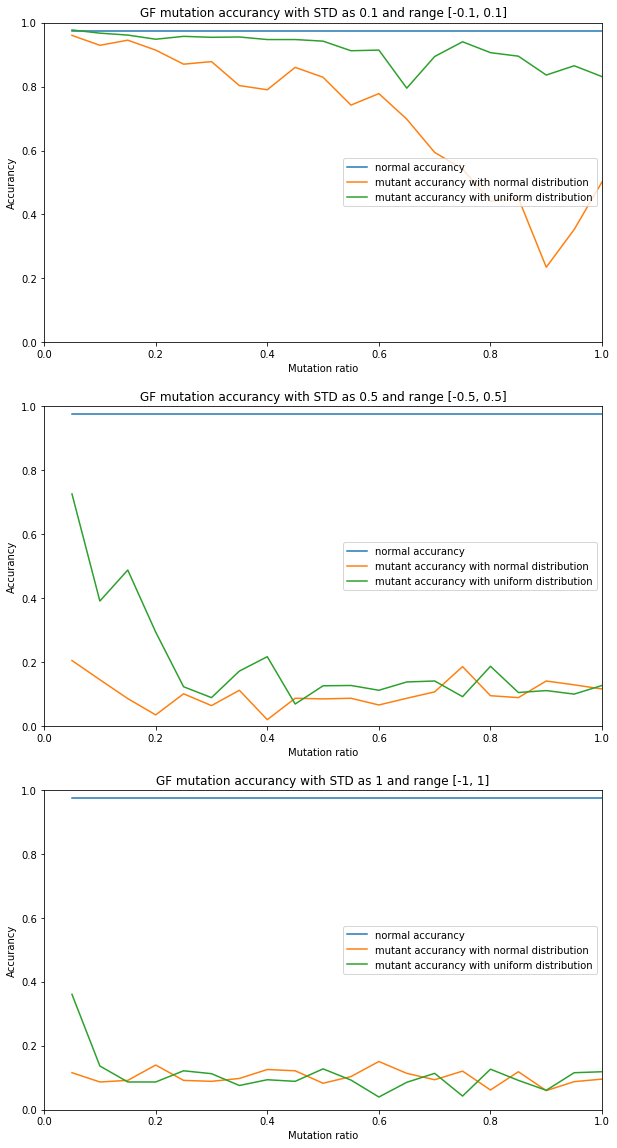

In [5]:
set_of_normal_accs = [normal_accs_1, normal_accs_2, normal_accs_3]
set_of_mutant_accs_normal = [mutant_accs_normal_1, mutant_accs_normal_2, mutant_accs_normal_3]
set_of_mutant_accs_uniform = [mutant_accs_uniform_1, mutant_accs_uniform_2, mutant_accs_uniform_3]
STDs = ['0.1', '0.5', '1']

plt.figure(figsize=(10, 20))

for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.axis([0, 1, 0, 1])
    plt.plot(mutation_ratios, set_of_normal_accs[i])
    plt.plot(mutation_ratios, set_of_mutant_accs_normal[i])
    plt.plot(mutation_ratios, set_of_mutant_accs_uniform[i])
    plt.legend(['normal accurancy', 'mutant accurancy with normal distribution', 'mutant accurancy with uniform distribution'], loc='center right')
    plt.title('GF mutation accurancy with STD as ' + STDs[i] + ' and range [-' + STDs[i] + ', ' + STDs[i] + ']')
    plt.xlabel('Mutation ratio')
    plt.ylabel('Accurancy')

plt.show()

In [6]:
def WS_experiment():
    normal_accs = []
    mutant_accs = []

    for mutation_ratio in mutation_ratios:
        trained_mutated_model = model_mut_opts.WS_mut(trained_model, mutation_ratio)
        trained_mutated_model = network.compile_model(trained_mutated_model)

        loss, acc = trained_model.evaluate(test_datas, test_labels, verbose=False)
        normal_accs.append(acc)
        mutant_loss, mutant_acc = trained_mutated_model.evaluate(test_datas, test_labels, verbose=False)
        mutant_accs.append(mutant_acc)
        
    return normal_accs, mutant_accs

normal_accs, mutant_accs = WS_experiment()

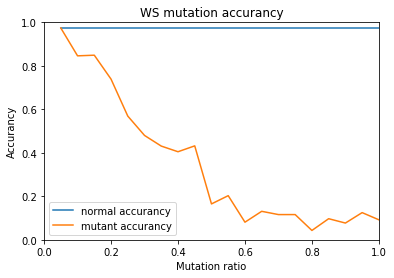

In [7]:
plt.axis([0, 1, 0, 1])
plt.plot(mutation_ratios, normal_accs)
plt.plot(mutation_ratios, mutant_accs)

plt.legend(['normal accurancy', 'mutant accurancy'], loc='lower left')
plt.title('WS mutation accurancy')
plt.xlabel('Mutation ratio')
plt.ylabel('Accurancy')
plt.show()

In [8]:
def NEB_experiment():
    normal_accs = []
    mutant_accs = []

    for mutation_ratio in mutation_ratios:
        trained_mutated_model = model_mut_opts.NEB_mut(trained_model, mutation_ratio)
        trained_mutated_model = network.compile_model(trained_mutated_model)

        loss, acc = trained_model.evaluate(test_datas, test_labels, verbose=False)
        normal_accs.append(acc)
        mutant_loss, mutant_acc = trained_mutated_model.evaluate(test_datas, test_labels, verbose=False)
        mutant_accs.append(mutant_acc)
        
    return normal_accs, mutant_accs

normal_accs, mutant_accs = NEB_experiment()

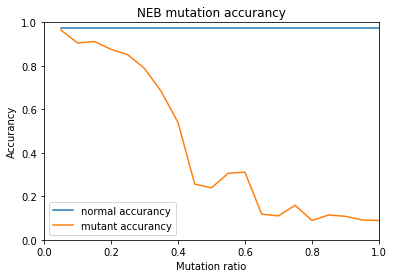

In [9]:
plt.axis([0, 1, 0, 1])
plt.plot(mutation_ratios, normal_accs)
plt.plot(mutation_ratios, mutant_accs)

plt.legend(['normal accurancy', 'mutant accurancy'], loc='lower left')
plt.title('NEB mutation accurancy')
plt.xlabel('Mutation ratio')
plt.ylabel('Accurancy')
plt.show()

In [10]:
def NAI_experiment():
    normal_accs = []
    mutant_accs = []

    for mutation_ratio in mutation_ratios:
        trained_mutated_model = model_mut_opts.NAI_mut(trained_model, mutation_ratio)
        trained_mutated_model = network.compile_model(trained_mutated_model)

        loss, acc = trained_model.evaluate(test_datas, test_labels, verbose=False)
        normal_accs.append(acc)
        mutant_loss, mutant_acc = trained_mutated_model.evaluate(test_datas, test_labels, verbose=False)
        mutant_accs.append(mutant_acc)
        
    return normal_accs, mutant_accs

normal_accs, mutant_accs = NAI_experiment()

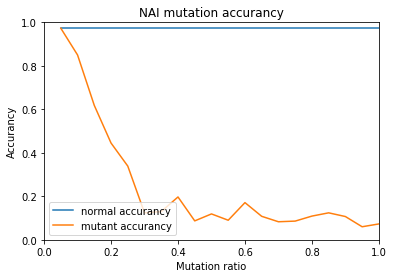

In [11]:
plt.axis([0, 1, 0, 1])
plt.plot(mutation_ratios, normal_accs)
plt.plot(mutation_ratios, mutant_accs)

plt.legend(['normal accurancy', 'mutant accurancy'], loc='lower left')
plt.title('NAI mutation accurancy')
plt.xlabel('Mutation ratio')
plt.ylabel('Accurancy')
plt.show()

In [12]:
def NS_experiment():
    normal_accs = []
    mutant_accs = []

    for mutation_ratio in mutation_ratios:
        trained_mutated_model = model_mut_opts.NS_mut(trained_model, mutation_ratio)
        trained_mutated_model = network.compile_model(trained_mutated_model)

        loss, acc = trained_model.evaluate(test_datas, test_labels, verbose=False)
        normal_accs.append(acc)
        mutant_loss, mutant_acc = trained_mutated_model.evaluate(test_datas, test_labels, verbose=False)
        mutant_accs.append(mutant_acc)
        
    return normal_accs, mutant_accs

normal_accs, mutant_accs = NS_experiment()

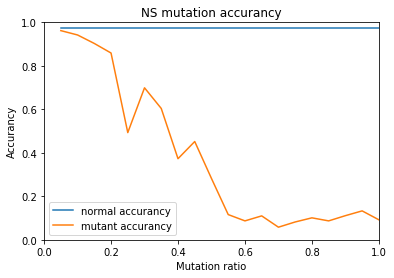

In [13]:
plt.axis([0, 1, 0, 1])
plt.plot(mutation_ratios, normal_accs)
plt.plot(mutation_ratios, mutant_accs)

plt.legend(['normal accurancy', 'mutant accurancy'], loc='lower left')
plt.title('NS mutation accurancy')
plt.xlabel('Mutation ratio')
plt.ylabel('Accurancy')
plt.show()